In [1]:
# Disable GPU
#import os
#os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
import os
import sys
import glob
import math
import pickle
import ctypes

import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
from scipy.stats import fisher_exact

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter, MaxNLocator

import seaborn as sns

import tensorflow as tf
from tensorflow.keras import utils

from sklearn.metrics import r2_score

from functools import partial
from multiprocessing import Pool
from joblib import Parallel, delayed
from pathlib import Path

from IPython.display import Image, display

import bayesflow as bf
import mvct_comp_functions_or as prior_simulator_functions

2025-12-03 12:59:06.912145: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-03 12:59:06.936751: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-03 12:59:06.936770: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-03 12:59:06.936787: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-03 12:59:06.941819: I tensorflow/core/platform/cpu_feature_g

In [3]:
# Helper function to pass variable N as shared context for model comparison
def variable_n_obs():
    n_obs = prior_simulator_functions.random_num_obs()
    return {'n_obs' : n_obs}

# Custom configurator to handle variable n_obs in model comparison
default_config = bf.configuration.DefaultModelComparisonConfigurator(num_models=2)

def variable_n_obs_configurator(forward_dict):
    config = default_config(forward_dict)
    batch_size = config['model_indices'].shape[0]
    config['direct_conditions'] = np.zeros((batch_size, 1), dtype=np.float32) + np.sqrt(forward_dict['n_obs'])
    return config

# Generative Model

In [4]:
# Generative model
PARAM_NAMES = ['t0', 'st0', 'zr', 'v1',  'v2', 'a', 'alpha', 'szr', 'sv']
PARAM_LABELS = [r"$t_0$", r"$s_{t_0}$", r"$z_r$", r"$v_{1}$", r"$v_{0}$", r"$a$", r"$\alpha$",
               r"$s_{z_r}$", r"$s_{v}$"]
MODEL_NAMES = ["LFM_st0", "LFM_all"]
MODEL_LABELS = ["Simple LFM", "Full LFM"]

# Neural networks
NUM_EPOCHS = 125
NUM_ITERATIONS_PER_EPOCH = 10000
BATCH_SIZE = 32
SUMMARY_NET_SETTINGS = {
    "summary_dim" : 16, 
    "num_dense_s1" : 3,
    "num_dense_s2" : 3,
    "num_dense_s3" : 3,
    "num_dense_equivariant" : 3
}
NUM_VAL_SAMPLES = 2000
NUM_ENSEMBLE_MEMBERS = 2

# Global
s = "no_deadline"
MY_NAME = "mvct_mod_comp_" + str(NUM_EPOCHS) + "ep"
PRESIM_PATH = "/media/administrator/Expansion/"
NUM_PROCESSES = 25 #os.cpu_count()
FIG_ROOT_PATH = "mvct/figures/"
MY_DPI = 600

print(MY_NAME)

mvct_mod_comp_125ep


In [5]:
#t0, st0, zr, v0, v1, a, alpha, szr, sv
prior_simulator_functions.levy_prior(fix_alpha=True,
                                     fix_st0=False,
                                     fix_szr=False, fix_sv=False, batch_size=2)

array([[ 2.9985399e+00,  7.0555693e-01,  7.6894391e-01, -2.4343586e-01,
        -8.4601350e-02,  6.9825940e+00,  2.0000000e+00,  3.1993225e-01,
         6.6007417e-01],
       [ 1.0890815e+01,  1.1825503e+00,  5.8332312e-01, -4.4706884e-01,
        -1.4716567e-01,  1.7041240e+00,  2.0000000e+00,  1.9602627e-03,
         8.4447521e-01]], dtype=float32)

In [6]:
# Prior functions
levy_prior_st0 = bf.simulation.Prior(batch_prior_fun=
                                 partial(prior_simulator_functions.levy_prior, fix_alpha=False,
                                         fix_st0 = False,
                                         fix_szr = True, fix_sv = True),
                                 param_names=PARAM_NAMES)
levy_prior_all = bf.simulation.Prior(batch_prior_fun=
                                 partial(prior_simulator_functions.levy_prior, fix_alpha=False,
                                         fix_st0 = False,
                                         fix_szr = False, fix_sv = False),
                                 param_names=PARAM_NAMES)

# Simulator functions
if s == "deadline":
    simulator = bf.simulation.Simulator(batch_simulator_fun=
                                        partial(prior_simulator_functions.batch_simulator, 
                                                deadline=True))
else:
    simulator = bf.simulation.Simulator(batch_simulator_fun=
                                        partial(prior_simulator_functions.batch_simulator, 
                                                deadline=False))

# Generative models
levy_model_st0 = bf.simulation.GenerativeModel(prior=levy_prior_st0, 
                                          simulator=simulator, name=MODEL_NAMES[0])
levy_model_all = bf.simulation.GenerativeModel(prior=levy_prior_all, 
                                          simulator=simulator, name=MODEL_NAMES[1])
meta_model = bf.simulation.MultiGenerativeModel([levy_model_st0, levy_model_all],
                                               shared_context_gen=variable_n_obs) 

INFO:root:Performing 2 pilot runs with the LFM_st0 model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 9)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 342, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:Performing 2 pilot runs with the LFM_all model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 9)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 352, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [7]:
def setup_network(checkpoint_path, 
                  summary_net_settings=SUMMARY_NET_SETTINGS,
                  generative_model=meta_model, 
                  configurator=variable_n_obs_configurator,
                  learning_rate=0.0001 
                 ):
    
    tf.keras.backend.clear_session()

    summary_net = bf.networks.DeepSet(
        summary_dim = summary_net_settings["summary_dim"],
        num_dense_s1 = summary_net_settings["num_dense_s1"],
        num_dense_s2 = summary_net_settings["num_dense_s2"],
        num_dense_s3 = summary_net_settings["num_dense_s3"],
        num_equiv = summary_net_settings["num_dense_equivariant"]
    )

    inference_net = bf.inference_networks.PMPNetwork(num_models=2, num_dense=5, dropout=False)
    amortizer = bf.amortizers.AmortizedModelComparison(inference_net, summary_net)
    
    trainer = bf.trainers.Trainer(amortizer=amortizer, 
                                  generative_model=generative_model,
                                  configurator=configurator, 
                                  checkpoint_path=checkpoint_path, 
                                  default_lr=learning_rate,
                                  memory=True)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=
                                     tf.keras.optimizers.schedules.CosineDecay(
                                         learning_rate, NUM_ITERATIONS_PER_EPOCH*NUM_EPOCHS))
    
    return amortizer, trainer, optimizer

## Priors

In [8]:
def custom_plot_prior(prior_samples, my_linewidth = 1, my_axis_linewidth = 0.5, my_fontsize = 12, dpi=600):
    n_params = prior_samples.shape[1]
    n_cols = 3 
    n_rows = (n_params + n_cols - 1) // n_cols
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(8, 6))
    axs = axs.flatten()  
    
    for i in range(n_params):
        ax = axs[i]
        data = prior_samples[:, i]
        mean_value = np.mean(data)

        ax.hist(data, bins=50, color='#1E1E1E', alpha=0.6)
        ax.tick_params(axis='both', labelsize=my_fontsize)
        
        ax.axvline(mean_value, color="#8f2727", linestyle='-', linewidth=3)
        
        ax.set_title(PARAM_LABELS[i], fontsize=my_fontsize+2)
        if i % n_cols == 0:  
            ax.set_ylabel('Frequency', fontsize=my_fontsize+2)
            
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(my_axis_linewidth)
        ax.spines['bottom'].set_linewidth(my_axis_linewidth)
        
    for i in range(n_params, len(axs)):
        axs[i].axis('off')
    
    plt.tight_layout()
    
    save_path = Path(FIG_ROOT_PATH) / "figA1_priors.png"
    if not save_path.exists():
        plt.savefig(save_path, dpi=MY_DPI, bbox_inches="tight")
        print(f"Figure saved to {save_path}")
    else:
        print(f"Figure already exists, not overwritten: {save_path}")
        
    plt.show()

Figure already exists, not overwritten: mvct/figures/figA1_priors.png


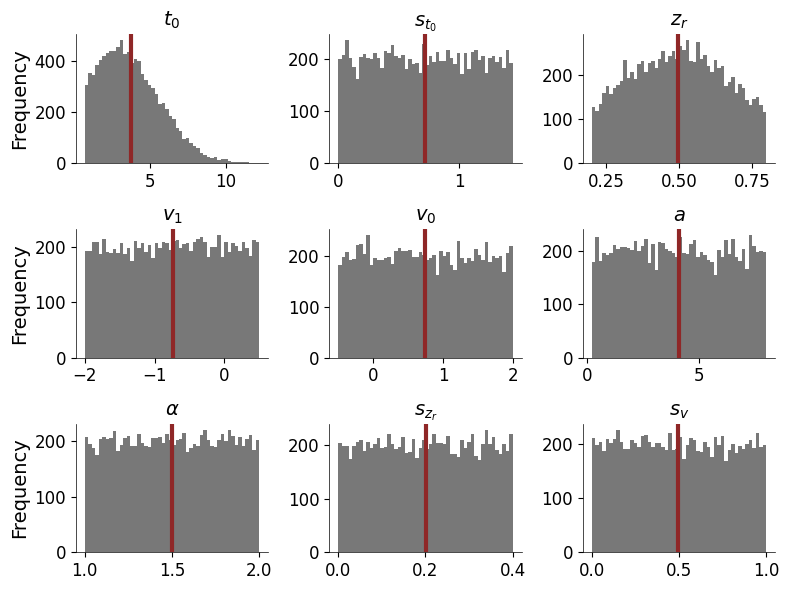

In [9]:
full_levy_prior_samples = prior_simulator_functions.levy_prior(fix_alpha=False, fix_st0=False, fix_szr=False, fix_sv=False, batch_size=10000)
custom_plot_prior(full_levy_prior_samples)

# Neural Network Training

## Pre-Simulation

In [10]:
def f(x, presim_path):
    file_path = os.path.join(presim_path, f'presim_file_{x}.pkl')
    with open(file_path, 'wb+') as file:
        for k in range(NUM_ITERATIONS_PER_EPOCH):
            presim_res = meta_model(BATCH_SIZE)
            pickle.dump(presim_res, file)

def multipickle_loader(file_path):
    sim_dicts = []
    with open(file_path, 'rb') as f:
        try:
            while True:
                sim_dicts.append(pickle.load(f))
        except EOFError:
            pass
    return sim_dicts

In [ ]:
if __name__ == '__main__':
    FULL_PRESIM_PATH = os.path.join(PRESIM_PATH, MY_NAME)
    if not os.path.exists(FULL_PRESIM_PATH):
        os.makedirs(FULL_PRESIM_PATH)
        with Pool(processes=NUM_PROCESSES) as pool:
            presim_function = partial(f, presim_path=FULL_PRESIM_PATH)
            pool.map(presim_function, range(NUM_EPOCHS))

## Training Phase

2025-12-03 12:59:15.195844: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-03 12:59:15.199146: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-03 12:59:15.199249: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

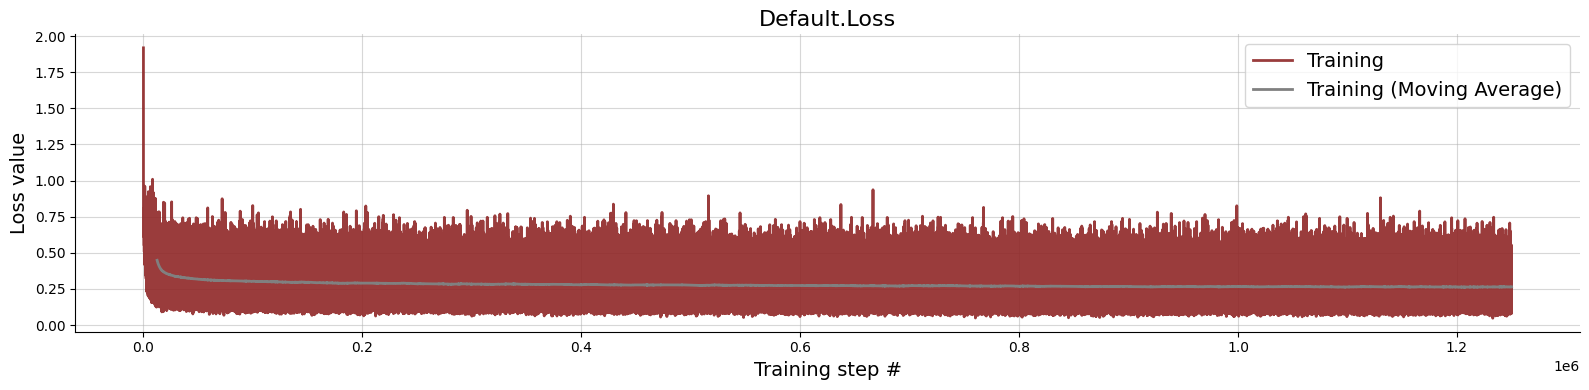

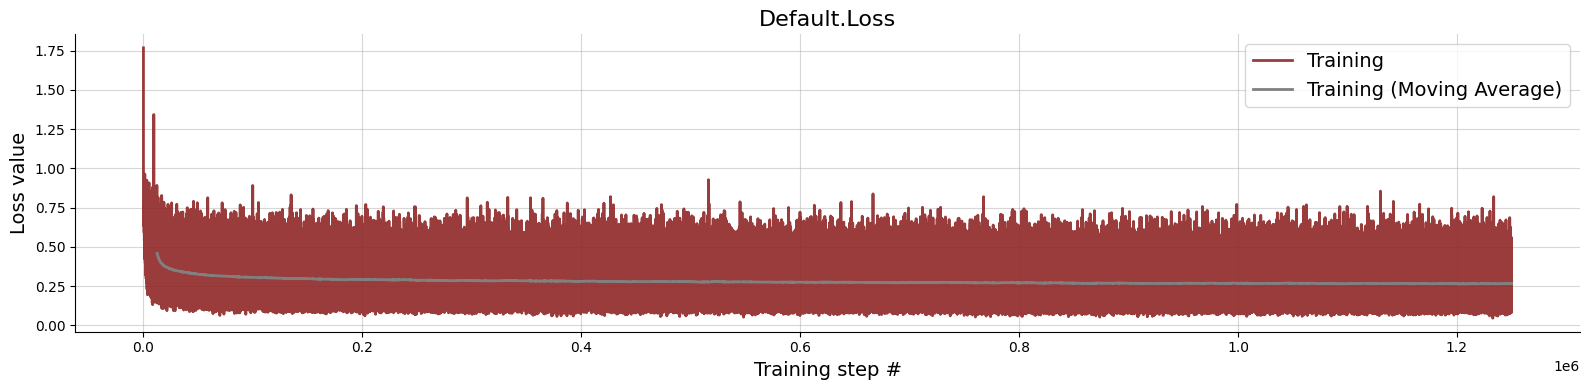

In [11]:
for network in range(NUM_ENSEMBLE_MEMBERS):
    amortizer, trainer, optimizer = setup_network(checkpoint_path=f"checkpoint_{MY_NAME}/net{network+1}")
    if not os.path.exists(f"checkpoint_{MY_NAME}/net{network+1}"):
        losses = trainer.train_from_presimulation(FULL_PRESIM_PATH,
                                                  optimizer=optimizer,
                                                  reuse_optimizer=True,
                                                  custom_loader=multipickle_loader)
    diag_plot = bf.diagnostics.plot_losses(trainer.loss_history.get_plottable(), moving_average=True)

## Network Validation

In [12]:
def save_data(data, file_path):
    with open(file_path, "wb") as f:
        pickle.dump(data, f)

def load_data(file_path):
    with open(file_path, "rb") as f:
        return pickle.load(f)

In [13]:
VAL_ROOT_PATH = "mvct/validation"
os.makedirs(VAL_ROOT_PATH, exist_ok=True)

for network in range(NUM_ENSEMBLE_MEMBERS):
    SIM_INDICES_FILE = f"{VAL_ROOT_PATH}/sim_indices_{MY_NAME}_net{network+1}.pkl"
    SIM_PRED_FILE = f"{VAL_ROOT_PATH}/sim_pred_{MY_NAME}_net{network+1}.pkl"

    if all(os.path.exists(file) for file in [SIM_INDICES_FILE, SIM_PRED_FILE]):
        print(f"Data already exists for Network {network+1}.")
    else:
        print("generating new data...")
        amortizer, trainer, optimizer = setup_network(checkpoint_path=f"checkpoint_{MY_NAME}/net{network+1}")
        sim_data = meta_model(NUM_VAL_SAMPLES)
        sim_data_transformed = variable_n_obs_configurator(sim_data)
        sim_indices = sim_data_transformed["model_indices"]
        sim_pred = amortizer(sim_data_transformed)
        print("saving data...")
        save_data(sim_indices, SIM_INDICES_FILE)
        save_data(sim_pred, SIM_PRED_FILE)
        print("data saved successfully")

Data already exists for Network 1.
Data already exists for Network 2.


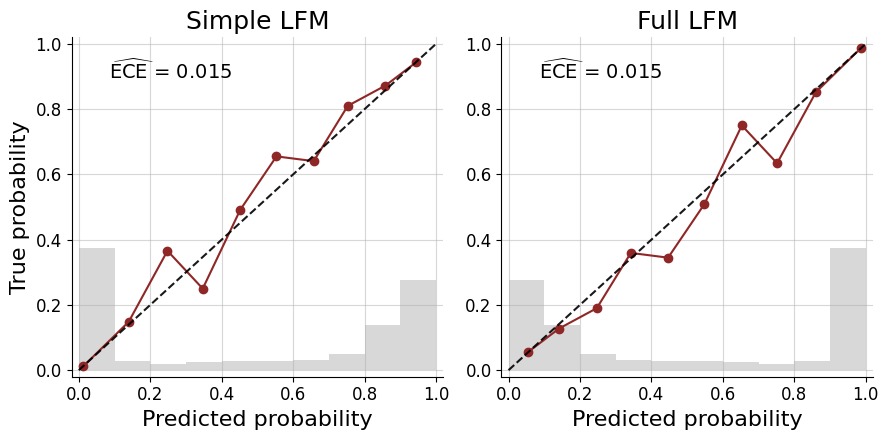

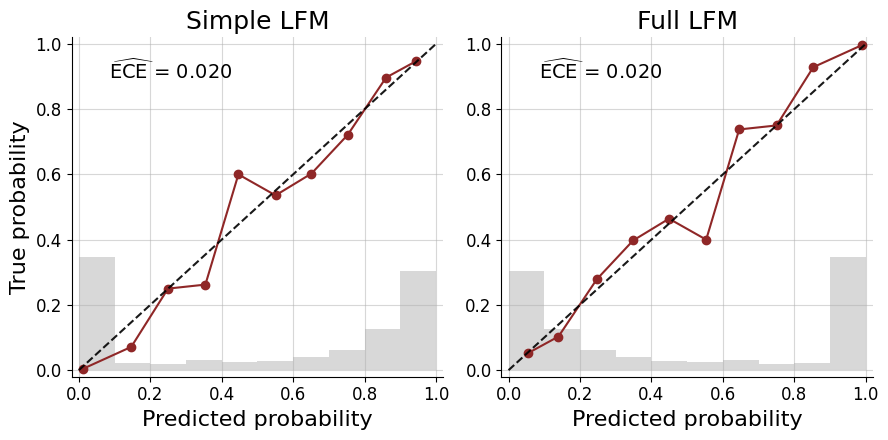

In [14]:
for network in range(NUM_ENSEMBLE_MEMBERS):
    SIM_INDICES_FILE = f"{VAL_ROOT_PATH}/sim_indices_{MY_NAME}_net{network+1}.pkl"
    SIM_PRED_FILE = f"{VAL_ROOT_PATH}/sim_pred_{MY_NAME}_net{network+1}.pkl"
    sim_indices = load_data(SIM_INDICES_FILE)
    sim_pred = load_data(SIM_PRED_FILE)
    bf.diagnostics.plot_calibration_curves(true_models=sim_indices,
                                           pred_models=sim_pred,
                                           model_names=MODEL_LABELS,
                                           fig_size=(9, 4.5)
                                          )
    plt.savefig(f"{FIG_ROOT_PATH}/figB1_calibration_net{network+1}.png", 
                dpi=MY_DPI, bbox_inches="tight")

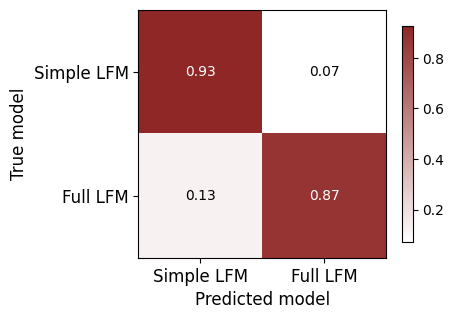

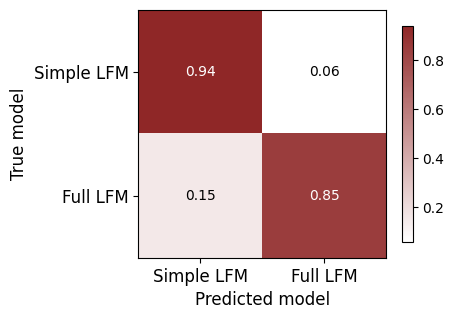

In [15]:
for network in range(NUM_ENSEMBLE_MEMBERS):
    SIM_INDICES_FILE = f"{VAL_ROOT_PATH}/sim_indices_{MY_NAME}_net{network+1}.pkl"
    SIM_PRED_FILE = f"{VAL_ROOT_PATH}/sim_pred_{MY_NAME}_net{network+1}.pkl"
    sim_indices = load_data(SIM_INDICES_FILE)
    sim_pred = load_data(SIM_PRED_FILE)
    conf_matrix = bf.diagnostics.plot_confusion_matrix(true_models=sim_indices, 
                                                       pred_models=sim_pred,
                                                       model_names=MODEL_LABELS,
                                                       fig_size=(4, 4),
                                                       title=False
                                                      )
    plt.savefig(f"{FIG_ROOT_PATH}/figB2_confusion_net{network+1}.png", 
                dpi=MY_DPI, bbox_inches="tight")

# Network Application

In [16]:
# Load empirical data
DATA_ROOT_PATH = f"mvct/behav_demo_data/prepared2/"
ESTIM_ROOT_PATH = "mvct/estimates_mod_comp"
os.makedirs(ESTIM_ROOT_PATH, exist_ok=True)
NUM_STUDIES=2

In [17]:
for network in range(NUM_ENSEMBLE_MEMBERS):
    for study in range(NUM_STUDIES):
        estimates_path = f'{ESTIM_ROOT_PATH}/{MY_NAME}_study{study+1}_net{network+1}.csv'
        
        if not os.path.exists(estimates_path):  
            amortizer, trainer, optimizer = setup_network(
                checkpoint_path=f"checkpoint_{MY_NAME}/net{network+1}"
            )
            data_path = os.path.join(DATA_ROOT_PATH, f'study{study+1}_tukey1.5/')
            datafiles = glob.glob(data_path + '*.csv') 
            preds = []   
            
            for datafile in datafiles:
                raw_data = pd.read_csv(datafile)
                data = np.expand_dims(raw_data.to_numpy(), 0)
                data = np.delete(data, 2, axis=2) #Delete half column
                thisdict = {"summary_conditions": data, 
                            "direct_conditions": np.zeros((1, 1), dtype=np.float32) + np.sqrt(data.shape[1])}
                samples = amortizer.posterior_probs(thisdict, to_numpy=True)
                preds.append(samples)
                
            preds = np.array(preds)[:, 0, :]
            df = pd.DataFrame(preds, columns=MODEL_NAMES)
            df['file'] = [os.path.basename(filepath) for filepath in datafiles]  
            df[['pp', 'condition', 'ans', 'att', 'acc']] = df['file'].str.extract(
                r'pp(\d+)_(guess|control)_ans(\d+)_att(\d+)_acc(\d+)\.csv$'
            )
            df = df.astype({'att': int, 'acc': int})
            df.to_csv(estimates_path, index=False)
            
            print(f"Saved estimates to {estimates_path}")
        else:
            print(f"{estimates_path} already exists")

mvct/estimates_mod_comp/mvct_mod_comp_125ep_study1_net1.csv already exists
mvct/estimates_mod_comp/mvct_mod_comp_125ep_study2_net1.csv already exists
mvct/estimates_mod_comp/mvct_mod_comp_125ep_study1_net2.csv already exists
mvct/estimates_mod_comp/mvct_mod_comp_125ep_study2_net2.csv already exists


## Ensemble Agreement

In [18]:
def plot_ensemble_agreement(
    net1_estimates,
    net2_estimates,
    param_names=None,
    fig_size=None,
    label_fontsize=16,
    title_fontsize=18,
    metric_fontsize=16,
    tick_fontsize=12,
    add_corr=True,
    add_r2=True,
    color="#8f2727",
    n_col=None,
    n_row=None,
    xlabel="Network 1",
    ylabel="Network 2",
    study=None,
    **kwargs,
):
    """ Alters bf.diagnostics.plot_recovery to show the degree of agreement between two ensemble members."""

    n_params = net1_estimates.shape[-1]
    if param_names is None:
        param_names = [f"$\\theta_{{{i}}}$" for i in range(1, n_params + 1)]

    if n_row is None and n_col is None:
        n_row = int(np.ceil(n_params / 6))
        n_col = int(np.ceil(n_params / n_row))
    elif n_row is None and n_col is not None:
        n_row = int(np.ceil(n_params / n_col))
    elif n_row is not None and n_col is None:
        n_col = int(np.ceil(n_params / n_row))

    if fig_size is None:
        fig_size = (int(4 * n_col), int(4 * n_row))
    f, axarr = plt.subplots(n_row, n_col, figsize=fig_size)

    if n_col > 1 or n_row > 1:
        axarr_it = axarr.flat
    else:
        axarr_it = [axarr]

    for i, ax in enumerate(axarr_it):
        if i >= n_params:
            break

        _ = ax.scatter(net1_estimates[:, i], net2_estimates[:, i], alpha=0.5, color=color, **kwargs)

        lower = min(net1_estimates[:, i].min(), net2_estimates[:, i].min())
        upper = max(net1_estimates[:, i].max(), net2_estimates[:, i].max())
        eps = (upper - lower) * 0.1
        ax.set_xlim([lower - eps, upper + eps])
        ax.set_ylim([lower - eps, upper + eps])
        ax.plot(
            [ax.get_xlim()[0], ax.get_xlim()[1]],
            [ax.get_ylim()[0], ax.get_ylim()[1]],
            color="black",
            alpha=0.9,
            linestyle="dashed",
        )

        if add_r2:
            r2 = r2_score(net1_estimates[:, i], net2_estimates[:, i])
            ax.text(
                0.1,
                0.9,
                "$R^2$ = {:.3f}".format(r2),
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
                size=metric_fontsize,
            )
        if add_corr:
            corr = np.corrcoef(net1_estimates[:, i], net2_estimates[:, i])[0, 1]
            ax.text(
                0.1,
                0.8,
                "$r$ = {:.3f}".format(corr),
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
                size=metric_fontsize,
            )
        ax.set_title(param_names[i], fontsize=title_fontsize)

        # Prettify
        sns.despine(ax=ax)
        ax.grid(alpha=0.5)
        ax.tick_params(axis="both", which="major", labelsize=tick_fontsize)
        ax.tick_params(axis="both", which="minor", labelsize=tick_fontsize)


    bottom_row = axarr if n_row == 1 else axarr[0] if n_col == 1 else axarr[n_row - 1, :]
    for _ax in bottom_row:
        _ax.set_xlabel(xlabel, fontsize=label_fontsize)

    if n_row == 1:
        axarr[0].set_ylabel(ylabel, fontsize=label_fontsize)
    else:
        for _ax in axarr[:, 0]:
            _ax.set_ylabel(ylabel, fontsize=label_fontsize)

    for _ax in axarr_it[n_params:]:
        _ax.remove()

    annotation = "A" if study == 0 else "B"
    f.text(0.0, 0.975, annotation, fontsize=20, ha='left', fontweight='bold')

    f.tight_layout()
    return f

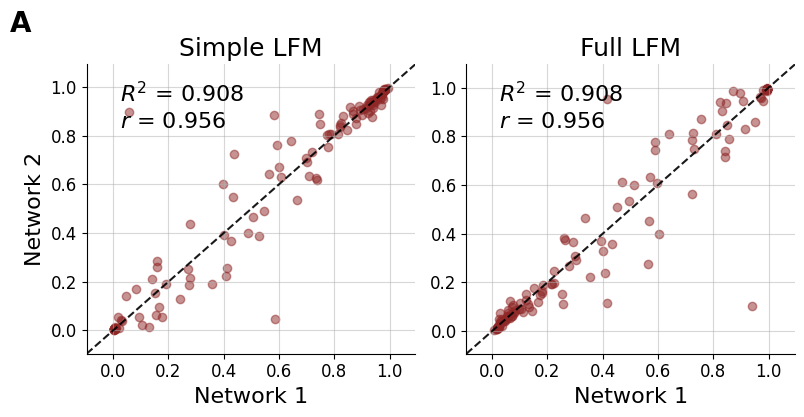

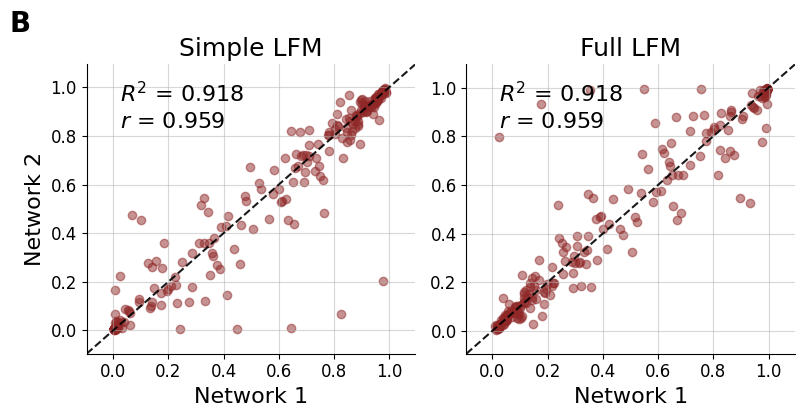

In [19]:
for study in range(NUM_STUDIES):
    net1_pred = pd.read_csv(f'{ESTIM_ROOT_PATH}/{MY_NAME}_study{study+1}_net1.csv', index_col='pp')
    net2_pred = pd.read_csv(f'{ESTIM_ROOT_PATH}/{MY_NAME}_study{study+1}_net2.csv', index_col='pp')
    net1_pred = net1_pred[MODEL_NAMES]
    net2_pred = net2_pred[MODEL_NAMES]
    
    plot_ensemble_agreement(
                net1_estimates=np.array(net1_pred), net2_estimates=np.array(net2_pred),
                xlabel="Network 1", ylabel="Network 2", study=study,
                param_names=MODEL_LABELS#, add_corr=False, add_r2=True
            )

    plt.savefig(f"{FIG_ROOT_PATH}/figB3_agreement_study{study+1}.png", dpi=MY_DPI, bbox_inches="tight")

## PMPs and BFs

In [20]:
def fmt(x):
    return f"{x:.2e}" if abs(x) < 0.01 and x != 0 else f"{x:.2f}"

def fmt_no_leading_zero(x):
    s = fmt(x)
    if "e" in s:
        return s
    if s.startswith("0."):
        return s[1:]
    if s.startswith("-0."):
        return "-" + s[2:]
    return s

def compute_counts(df, col_a, col_b, condition_col, conditions):
    result = {}
    for cond in conditions:
        df_cond = df[df[condition_col] == cond]
        n_total = len(df_cond)

        n_st0 = (df_cond[col_a] > df_cond[col_b]).sum()
        n_all = (df_cond[col_a] < df_cond[col_b]).sum()

        result[cond] = {
            "N_st0": f"{n_st0} ({fmt(n_st0 / n_total * 100)}%)",
            "N_all": f"{n_all} ({fmt(n_all / n_total * 100)}%)",
            "Nn_st0": n_st0,
            "Nn_all": n_all,
        }
    return result

def odds_ratio_ci_from_counts(n_st0_guess, n_all_guess, n_st0_control, n_all_control, alpha=0.05):
    a = float(n_st0_guess)
    b = float(n_all_guess)
    c = float(n_st0_control)
    d = float(n_all_control)

    if min(a, b, c, d) == 0:
        a += 0.5
        b += 0.5
        c += 0.5
        d += 0.5

    or_val = (a * d) / (b * c)
    log_or = math.log(or_val)
    se = math.sqrt(1 / a + 1 / b + 1 / c + 1 / d)

    if abs(alpha - 0.05) < 1e-9:
        z = 1.96
    else:
        z = scipy.stats.norm.ppf(1 - alpha / 2)

    ci_low = math.exp(log_or - z * se)
    ci_high = math.exp(log_or + z * se)
    return or_val, ci_low, ci_high

In [21]:
for network in range(NUM_ENSEMBLE_MEMBERS):
    print(f"\n--- Network {network + 1} ---")
    for study in range(NUM_STUDIES):
        print(f"\nStudy {study + 1}")
    
        my_pred = (
            pd.read_csv(
                f"{ESTIM_ROOT_PATH}/{MY_NAME}_study{study + 1}_net{network+1}.csv",
                index_col="pp",
            )
            .drop(columns=["file", "ans", "att", "acc"])
        )
    
        bf_df = my_pred.copy()
        reference_model = "LFM_st0"
    
        for model in MODEL_NAMES:
            if model != reference_model:
                bf_df[f"BF_{model}_vs_{reference_model}"] = bf_df[model] / bf_df[reference_model]
                bf_df[f"BF_{reference_model}_vs_{model}"] = bf_df[reference_model] / bf_df[model]
    
        summary_stats = bf_df.groupby("condition").agg(["median", "mean", "std"])
        summary_stats_transposed = summary_stats.transpose()
    
        pretty_table = pd.DataFrame()
        top_level_vars = summary_stats_transposed.index.get_level_values(0).unique()
    
        for cond in summary_stats_transposed.columns:
            formatted_col = []
            for var in top_level_vars:
                mean = summary_stats_transposed.loc[(var, "mean"), cond]
                std = summary_stats_transposed.loc[(var, "std"), cond]
                median = summary_stats_transposed.loc[(var, "median"), cond]

                if var in ["LFM_st0", "LFM_all"]:
                    formatter = fmt_no_leading_zero
                else:
                    formatter = fmt

                formatted_col.append(
                    f"M = {formatter(mean)}, SD = {formatter(std)}, Md = {formatter(median)}"
                )
            pretty_table[cond] = formatted_col
    
        pretty_table.index = ["P_st0", "P_all", "BF_all_vs_st0", "BF_st0_vs_all"]
    
        counts = compute_counts(my_pred, "LFM_st0", "LFM_all", "condition", ["control", "guess"])
    
        extra_rows = pd.DataFrame(
            {cond: [counts[cond]["N_st0"], counts[cond]["N_all"]] for cond in counts},
            index=["N_st0", "N_all"],
        )
    
        display(pretty_table)
        display(extra_rows)
    
        no_rows = pd.DataFrame(
            {cond: [counts[cond]["Nn_st0"], counts[cond]["Nn_all"]] for cond in counts},
            index=["Nn_st0", "Nn_all"],
        )
    
        a = int(no_rows.loc["Nn_st0", "guess"])
        b = int(no_rows.loc["Nn_all", "guess"])
        c = int(no_rows.loc["Nn_st0", "control"])
        d = int(no_rows.loc["Nn_all", "control"])
    
        or_val, ci_low, ci_high = odds_ratio_ci_from_counts(a, b, c, d)
    
        print(
            f"Odds ratio (guess vs control) = {or_val:.3f} "
            f"[95% CI {ci_low:.2f}, {ci_high:.2f}]"
        )
    
        try:
            table = [[a, b], [c, d]]
            _, p_fisher = fisher_exact(table, alternative="two-sided")
            print(f"Fisher's exact p = {p_fisher:.3f}")
        except Exception:
            pass


--- Network 1 ---

Study 1


,control,guess
P_st0,"M = .57, SD = .40, Md = .73","M = .58, SD = .36, Md = .65"
P_all,"M = .43, SD = .40, Md = .27","M = .42, SD = .36, Md = .35"
BF_all_vs_st0,"M = 35.12, SD = 72.27, Md = 0.37","M = 22.81, SD = 59.14, Md = 0.54"
BF_st0_vs_all,"M = 13.45, SD = 24.07, Md = 2.71","M = 9.25, SD = 13.89, Md = 1.94"


,control,guess
N_st0,39 (60.94%),39 (60.94%)
N_all,25 (39.06%),25 (39.06%)


Odds ratio (guess vs control) = 1.000 [95% CI 0.49, 2.03]
Fisher's exact p = 1.000

Study 2


,control,guess
P_st0,"M = .52, SD = .40, Md = .61","M = .53, SD = .38, Md = .66"
P_all,"M = .48, SD = .40, Md = .39","M = .47, SD = .38, Md = .34"
BF_all_vs_st0,"M = 35.51, SD = 69.73, Md = 0.63","M = 41.01, SD = 75.05, Md = 0.52"
BF_st0_vs_all,"M = 11.22, SD = 17.89, Md = 1.59","M = 6.91, SD = 12.32, Md = 1.91"


,control,guess
N_st0,68 (52.31%),76 (58.46%)
N_all,62 (47.69%),54 (41.54%)


Odds ratio (guess vs control) = 1.283 [95% CI 0.79, 2.09]
Fisher's exact p = 0.383

--- Network 2 ---

Study 1


,control,guess
P_st0,"M = .59, SD = .40, Md = .80","M = .57, SD = .38, Md = .68"
P_all,"M = .41, SD = .40, Md = .20","M = .43, SD = .38, Md = .32"
BF_all_vs_st0,"M = 36.98, SD = 79.77, Md = 0.24","M = 26.47, SD = 64.60, Md = 0.47"
BF_st0_vs_all,"M = 16.10, SD = 29.90, Md = 4.12","M = 10.87, SD = 20.89, Md = 2.15"


,control,guess
N_st0,40 (62.50%),38 (59.38%)
N_all,24 (37.50%),26 (40.62%)


Odds ratio (guess vs control) = 0.877 [95% CI 0.43, 1.78]
Fisher's exact p = 0.856

Study 2


,control,guess
P_st0,"M = .53, SD = .40, Md = .60","M = .51, SD = .38, Md = .61"
P_all,"M = .47, SD = .40, Md = .40","M = .49, SD = .38, Md = .39"
BF_all_vs_st0,"M = 37.10, SD = 75.01, Md = 0.68","M = 43.44, SD = 80.65, Md = 0.65"
BF_st0_vs_all,"M = 14.90, SD = 29.54, Md = 1.48","M = 6.93, SD = 12.73, Md = 1.55"


,control,guess
N_st0,69 (53.08%),72 (55.38%)
N_all,61 (46.92%),58 (44.62%)


Odds ratio (guess vs control) = 1.097 [95% CI 0.67, 1.79]
Fisher's exact p = 0.803
